# This notebook estimates and compares Einstein radii of candidates from each method based on Barnabe 2011 FDM of 61%
# EDIT 06/08/20 - Distances measured by Hubble relation are incorrect. Use astropy to calculate angular diameter distance. See how it affects $\Theta_E$ calculation.
# EDIT xx/xx/xx - Sliding F_DM from Auger2010.
# EDIT 26/06/20 - Trying it with 32% of stellar mass inside half the effective radius (from a de Vaucouleurs fit, Auger2010). '
# EDIT 27/06/20 - I messed up the distance relation for mac and zoo candidates... DON'T use Z2=2 * Z1... Use D2=2 * D1

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
#from matplotlib_venn import venn3, venn3_circles
import matplotlib.lines as lines
from astropy import constants as const
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
# import ephem
from astropy.cosmology import FlatLambdaCDM

In [4]:
#---------------------------------------------------------
#Constants, taken from mass_SFR.py done by former students
#---------------------------------------------------------
Mag_sun_w1 = 3.254
Mag_sun_error_w1 = np.sqrt(0.008**2+0.02**2) #extra 0!!
Mag_sun_kt = 3.302
Mag_sun_error_kt = np.sqrt(0.008**2+0.02**2)
lum_sun = 3.828e26 #in W from NASA fact sheet
c = const.c.to('km/s').value #c in km/s
nu_3 = (c*1000)/(11.5608e-6) #in s^-1 from Table 1 in Jarrett et al. (2011) (link: http://iopscience.iop.org/article/10.1088/0004-637X/735/2/112/pdf)
zp_3 = 31.674 #in Jy Table 1 this WISE guide: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example
a_3 = [1.13, 10.24] #Cluver14
a_4 = [0.82, 7.3] #Cluver14
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
h0_error = 2.4 # km/(Mpc*s)
parsec = 3.08567758e16 #m
jansky = 1e-26 #W/m^2/Hz
cosmo = FlatLambdaCDM(h0,Om0=0.262) # Shawn: to match cosmology used by Becky

In [5]:
### Samples as of 2/19/19
spec = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/spec_latest.csv')
mac = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/mac_latest.csv')
zoo = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_latest.csv')
zoo_30 = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_30_021920.csv')

## Estimate theta_e for spec candidates

In [50]:
z = 0.2 #[0.1, 0.2, 0.3, 0.4, 0.5]
dM = cosmo.comoving_distance(z)
dA = dM/(1.+z) # THIS IS THE ONE WE NEED
dA

<Quantity 649.22257696 Mpc>

In [63]:
Z1 = spec.z1

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
DA = cosmo.comoving_distance(Z1)/(1.0 + Z1)
DH = (c/h0)*Z1
# results in Mpc
pd.DataFrame(list(zip(Z1, DA, DH)))
#print(DA/DH)

,0,1,2
0,0.163,550.404560,662.143234
1,0.418,1091.821873,1698.011483
2,0.282,841.144837,1145.548417
3,0.128,449.006078,519.965239
4,0.313,905.072196,1271.477498
5,0.586,1313.706378,2380.465859
6,0.487,1193.014055,1978.305245
7,0.593,1321.275031,2408.901458
8,0.077,285.947704,312.791589
9,0.169,566.993938,686.516604


In [1]:
# estimate einstein radius
M = spec.STELLAR_MASS/0.39 # total mass assuming FDM 0.61%
Z1 = spec.z1
Z2 = spec.z2

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
B_H = ((h0/c)*(abs(Z1 - Z2)/(Z1*Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)
spec['theta_e_H0'] = A * B_H
spec['theta_e_Ang'] = A * B
#spec['theta_e_comdist'] = A*B #gives arcsecs


NameError: name 'spec' is not defined

# From this point, we have two measurements, theta_e_H0 is Hubble Law. theta_e_Ang is angular diameter distance.

In [71]:
#spec.to_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/spec_latest.csv')

## Estimate Einstein radii for Mac candidates

In [72]:
# estimate einstein radius
M = mac.STELLAR_MASS/0.39 # total mass assuming FDM 0.61%
Z1 = mac.Z
Z2 = 2*mac.Z

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
B_H = ((h0/c)*(1/(Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)

mac['theta_e_H0'] = A*B_H
mac['theta_e_Ang'] = A*B #gives arcsecs
mac

,Unnamed: 0,GAMA_ID,ID,RA,DEC,SCORE,STELLAR_MASS,Z,theta_e,theta_e_H0,theta_e_Ang
0,0,3899011.0,2251.0,131.33397,-0.91563,64.0,3.294000e+11,0.4027,1.448577,1.448577,1.364566
1,1,376338.0,2660.0,132.98734,1.50468,30.0,3.034000e+11,0.3272,1.542310,1.542310,1.484974
2,2,323152.0,2967.0,130.54643,1.64325,30.0,8.277000e+11,0.7216,1.715374,1.715374,1.354724
3,3,663364.0,2669.0,140.35284,-0.97414,28.0,2.688000e+11,0.3221,1.463153,1.463153,1.410552
4,4,3629152.0,1933.0,135.88864,-0.97487,26.0,2.129000e+11,0.4059,1.159976,1.159976,1.091547
5,5,3575500.0,1906.0,129.23265,-1.57512,26.0,3.209000e+11,0.3652,1.501378,1.501378,1.430787
6,6,197972.0,2007.0,137.85838,-0.75280,24.0,3.551000e+11,0.3373,1.643379,1.643379,1.578190
7,7,3883690.0,2756.0,134.57492,-1.55142,22.0,1.362000e+11,0.2481,1.186713,1.186713,1.162201
8,8,3911769.0,1704.0,138.66089,-1.11639,20.0,1.740000e+11,0.2794,1.263956,1.263956,1.230377
9,9,371400.0,2275.0,131.20438,1.00064,18.0,2.021000e+11,0.2948,1.326142,1.326142,1.286658


In [74]:
#mac.to_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/mac_latest.csv')

# Now estimate for all Zoo candidates.

In [75]:
# estimate einstein radius
M = zoo.STELLAR_MASS/0.39 # total mass assuming FDM 0.61%
Z1 = zoo.Z
Z2 = 2*zoo.Z

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
B_H = ((h0/c)*(1/(Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)

zoo['theta_e_H0'] = A*B_H
zoo['theta_e_Ang'] = A*B #gives arcsecs
zoo

,Unnamed: 0,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS,theta_e,theta_e_H0,theta_e_Ang
0,0,511867,216.38846,-1.11396,0.352229,5.459000e+10,0.0550,1.399744e+11,1.595680,1.595680,1.594227
1,1,485873,217.75015,-1.80042,0.349456,4.908000e+10,0.0539,1.258462e+11,1.528370,1.528370,1.527035
2,2,70022,178.02218,0.07392,0.368109,8.046000e+10,0.0599,2.063077e+11,1.856296,1.856296,1.854285
3,3,170898,176.46563,-2.33643,0.336096,2.319000e+11,0.1215,5.946154e+11,2.212752,2.212752,2.202493
4,4,184275,175.91698,-1.44119,0.317262,4.411000e+10,0.1237,1.131026e+11,0.956432,0.956432,0.951830
5,5,84050,175.79849,0.47814,0.365758,5.471000e+10,0.1190,1.402821e+11,1.086001,1.086001,1.081179
6,6,7104,175.71213,0.83228,0.333333,1.768000e+10,0.0751,4.533333e+10,0.777126,0.777126,0.775789
7,7,55245,181.07958,-0.31553,0.314054,1.274000e+11,0.0936,3.266667e+11,1.868604,1.868604,1.863550
8,8,70282,179.40308,0.12562,0.655352,4.256000e+10,0.1074,1.091282e+11,1.008252,1.008252,1.004631
9,9,185451,180.28326,-1.61006,0.302985,8.222000e+10,0.1079,2.108205e+11,1.398133,1.398133,1.393063


# Plot all three against previous plot.

/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 7.,  9.,  8., 13.,  6.,  3.,  0.,  0.,  0.,  1.]),
 array([0.90757458, 1.08018069, 1.2527868 , 1.42539291, 1.59799901,
        1.77060512, 1.94321123, 2.11581734, 2.28842344, 2.46102955,
        2.63363566]),
 <a list of 1 Patch objects>)

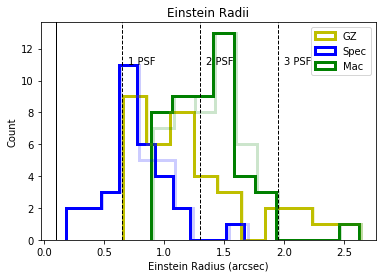

In [81]:
# Histogram of Einstein Radii
plt.xlabel("Einstein Radius (arcsec)")
plt.ylabel("Count")
plt.title("Einstein Radii")
plt.hist(zoo.theta_e_Ang,bins=10,color='y',label='GZ', histtype = 'step', linewidth=3)
plt.hist(spec.theta_e_Ang,bins=10,color='b',label='Spec', histtype = 'step', linewidth=3)
plt.hist(mac.theta_e_Ang,bins=10,color='g',label='Mac', histtype = 'step', linewidth=3)
#plt.hist(spec_121519.theta_e_chabrier,bins=10,color='b',label='GAMA', histtype = 'step', linewidth=3)
plt.legend(loc='upper right')
plt.axvline(0.65, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.3, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.95, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.1, color='k', linestyle='solid', linewidth=1)
#plt.axvline(1, color='g', linestyle='dashed', linewidth=1)
plt.text(0.7, 11, '1 PSF')
plt.text(1.35, 11, '2 PSF')
plt.text(2, 11, '3 PSF')
#plt.text(1.05, 12, 'GAMA aperture', color='b', fontsize=8)
#plt.text(1.05, 13, 'minimum from training set Petrillo-2019', color = 'g', fontsize=8)
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/allmethods_theta_e.png')
plt.hist(zoo.theta_e_H0,bins=10,color='y',label='GZ', histtype = 'step', linewidth=3, alpha = 0.2)
plt.hist(spec.theta_e_H0,bins=10,color='b',label='Spec', histtype = 'step', linewidth=3,  alpha = 0.2)
plt.hist(mac.theta_e_H0,bins=10,color='g',label='Mac', histtype = 'step', linewidth=3,  alpha = 0.2)

#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/revised_theta_e_060320.png')

# Now let's calculate mass from dark matter fractions calculated using the logarithmic fit.

In [82]:
spec['f_dm'] = 0.13 * np.log10(spec.STELLAR_MASS/(10**11)) + 0.54
mac['f_dm'] =  0.13 * np.log10(mac.STELLAR_MASS/(10**11)) + 0.54
zoo['f_dm'] =  0.13 * np.log10(zoo.STELLAR_MASS/(10**11)) + 0.54

In [135]:
# estimate einstein radius
M = spec.STELLAR_MASS/(1 - spec.f_dm) # total mass assuming FDM 0.61%
Z1 = spec.z1
Z2 = spec.z2

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
B_H = ((h0/c)*(abs(Z1 - Z2)/(Z1*Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)
spec['theta_e_H0_slide'] = A * B_H
spec['theta_e_Ang_slide'] = A * B
#spec['theta_e_comdist'] = A*B #gives arcsecs
spec['D1'] = D1
spec['D2'] = D2
spec

,Unnamed: 0,Unnamed: 0.1,RA,DEC,z1,z2,spec_type,GAMA_ID,STELLAR_MASS,max_total_mass,...,theta_e2,z_lens,theta_e_reckoning,theta_e_Ang,theta_e_H0,f_dm,theta_e_H0_slide,theta_e_Ang_slide,D1,D2
0,0,0,138.28150,-0.66673,0.163,0.321,PG+ELG,198082,3.025000e+10,1.655791e+11,...,0.556251,0.163,0.684590,0.678835,0.684590,0.472494,0.588639,0.583691,550.404560,920.870899
1,1,1,129.69546,-0.38179,0.418,0.738,PG+ELG,202448,NaN,4.820062e+11,...,NaN,0.418,NaN,NaN,NaN,NaN,NaN,NaN,1091.821873,1453.894831
2,2,2,136.63883,-0.35203,0.282,0.449,PG+ELG,204140,8.578000e+10,3.790958e+11,...,0.346664,0.282,0.761884,0.745710,0.761884,0.531340,0.695012,0.680258,841.144837,1139.193183
3,3,3,132.36771,0.16360,0.128,0.603,PG+ELG,209222,1.425000e+10,8.124632e+10,...,0.897134,0.128,0.670774,0.662165,0.670774,0.429996,0.554842,0.547721,449.006078,1331.883596
4,4,4,132.61013,0.11972,0.313,0.608,PG+ELG,209295,8.456000e+10,3.225492e+11,...,0.417813,0.313,0.820078,0.793199,0.820078,0.530531,0.747453,0.722955,905.072196,1337.099317
5,5,5,140.14187,0.97341,0.586,0.336,PG+ELG,279956,NaN,-3.937920e+11,...,NaN,0.336,NaN,NaN,NaN,NaN,NaN,NaN,1313.706378,949.752128
6,6,6,135.32929,1.22984,0.487,0.247,PG+ELG,301818,1.215000e+11,-2.506021e+11,...,0.677986,0.247,1.115235,1.092760,1.115235,0.550995,1.039377,1.018430,1193.014055,763.490542
7,7,7,138.94058,1.33144,0.593,0.404,PG+ELG,302719,1.474000e+11,-6.337884e+11,...,0.245262,0.404,0.772409,0.740118,0.772409,0.561905,0.728778,0.698311,1321.275031,1069.345169
8,8,8,130.50925,1.02071,0.077,0.699,PG+ELG,371208,4.812000e+09,4.326608e+10,...,1.110453,0.077,0.534146,0.529362,0.534146,0.368702,0.419831,0.416071,285.947704,1422.419853
9,9,9,137.90642,1.62916,0.169,0.334,PG+ELG,377486,NaN,1.710485e+11,...,NaN,0.169,NaN,NaN,NaN,NaN,NaN,NaN,566.993938,945.956283


In [84]:
# estimate einstein radius
M = mac.STELLAR_MASS/(1 - mac.f_dm) # total mass assuming FDM 0.61%
Z1 = mac.Z
Z2 = 2*mac.Z

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
B_H = ((h0/c)*(1/(Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)

mac['theta_e_H0_slide'] = A*B_H
mac['theta_e_Ang_slide'] = A*B #gives arcsecs
mac

,Unnamed: 0,GAMA_ID,ID,RA,DEC,SCORE,STELLAR_MASS,Z,theta_e,theta_e_H0,theta_e_Ang,f_dm,theta_e_H0_slide,theta_e_Ang_slide
0,0,3899011.0,2251.0,131.33397,-0.91563,64.0,3.294000e+11,0.4027,1.448577,1.448577,1.364566,0.607304,1.443596,1.359874
1,1,376338.0,2660.0,132.98734,1.50468,30.0,3.034000e+11,0.3272,1.542310,1.542310,1.484974,0.602662,1.528002,1.471198
2,2,323152.0,2967.0,130.54643,1.64325,30.0,8.277000e+11,0.7216,1.715374,1.715374,1.354724,0.659323,1.835354,1.449480
3,3,663364.0,2669.0,140.35284,-0.97414,28.0,2.688000e+11,0.3221,1.463153,1.463153,1.410552,0.595826,1.437268,1.385597
4,4,3629152.0,1933.0,135.88864,-0.97487,26.0,2.129000e+11,0.4059,1.159976,1.159976,1.091547,0.582663,1.121341,1.055191
5,5,3575500.0,1906.0,129.23265,-1.57512,26.0,3.209000e+11,0.3652,1.501378,1.501378,1.430787,0.605828,1.493411,1.423195
6,6,197972.0,2007.0,137.85838,-0.75280,24.0,3.551000e+11,0.3373,1.643379,1.643379,1.578190,0.611546,1.646645,1.581326
7,7,3883690.0,2756.0,134.57492,-1.55142,22.0,1.362000e+11,0.2481,1.186713,1.186713,1.162201,0.557443,1.114021,1.091010
8,8,3911769.0,1704.0,138.66089,-1.11639,20.0,1.740000e+11,0.2794,1.263956,1.263956,1.230377,0.571271,1.205516,1.173490
9,9,371400.0,2275.0,131.20438,1.00064,18.0,2.021000e+11,0.2948,1.326142,1.326142,1.286658,0.579724,1.277482,1.239447


In [85]:
# estimate einstein radius
M = zoo.STELLAR_MASS/(1 - zoo.f_dm) # total mass assuming FDM 0.61%
Z1 = zoo.Z
Z2 = 2*zoo.Z

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
B_H = ((h0/c)*(1/(Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)

zoo['theta_e_H0_slide'] = A*B_H
zoo['theta_e_Ang_slide'] = A*B #gives arcsecs
zoo

,Unnamed: 0,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS,theta_e,theta_e_H0,theta_e_Ang,f_dm,theta_e_H0_slide,theta_e_Ang_slide
0,0,511867,216.38846,-1.11396,0.352229,5.459000e+10,0.0550,1.399744e+11,1.595680,1.595680,1.594227,0.505825,1.417547,1.416257
1,1,485873,217.75015,-1.80042,0.349456,4.908000e+10,0.0539,1.258462e+11,1.528370,1.528370,1.527035,0.499818,1.349573,1.348395
2,2,70022,178.02218,0.07392,0.368109,8.046000e+10,0.0599,2.063077e+11,1.856296,1.856296,1.854285,0.527725,1.686872,1.685045
3,3,170898,176.46563,-2.33643,0.336096,2.319000e+11,0.1215,5.946154e+11,2.212752,2.212752,2.202493,0.587489,2.151530,2.141555
4,4,184275,175.91698,-1.44119,0.317262,4.411000e+10,0.1237,1.131026e+11,0.956432,0.956432,0.951830,0.493790,0.839501,0.835461
5,5,84050,175.79849,0.47814,0.365758,5.471000e+10,0.1190,1.402821e+11,1.086001,1.086001,1.081179,0.505949,0.964887,0.960603
6,6,7104,175.71213,0.83228,0.333333,1.768000e+10,0.0751,4.533333e+10,0.777126,0.777126,0.775789,0.442173,0.649792,0.648674
7,7,55245,181.07958,-0.31553,0.314054,1.274000e+11,0.0936,3.266667e+11,1.868604,1.868604,1.863550,0.553672,1.746717,1.741993
8,8,70282,179.40308,0.12562,0.655352,4.256000e+10,0.1074,1.091282e+11,1.008252,1.008252,1.004631,0.491770,0.883225,0.880053
9,9,185451,180.28326,-1.61006,0.302985,8.222000e+10,0.1079,2.108205e+11,1.398133,1.398133,1.393063,0.528947,1.272172,1.267559


/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 7.,  9.,  8., 13.,  6.,  3.,  0.,  0.,  0.,  1.]),
 array([0.90757458, 1.08018069, 1.2527868 , 1.42539291, 1.59799901,
        1.77060512, 1.94321123, 2.11581734, 2.28842344, 2.46102955,
        2.63363566]),
 <a list of 1 Patch objects>)

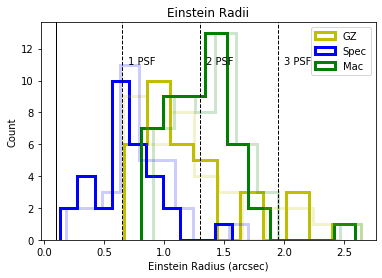

In [124]:
# Histogram of Einstein Radii
plt.xlabel("Einstein Radius (arcsec)")
plt.ylabel("Count")
plt.title("Einstein Radii")
plt.hist(zoo.theta_e_Ang_slide,bins=10,color='y',label='GZ', histtype = 'step', linewidth=3)
plt.hist(spec.theta_e_Ang_slide,bins=10,color='b',label='Spec', histtype = 'step', linewidth=3)
plt.hist(mac.theta_e_Ang_slide,bins=10,color='g',label='Mac', histtype = 'step', linewidth=3)
#plt.hist(spec_121519.theta_e_chabrier,bins=10,color='b',label='GAMA', histtype = 'step', linewidth=3)
plt.legend(loc='upper right')
plt.axvline(0.65, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.3, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.95, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.1, color='k', linestyle='solid', linewidth=1)
#plt.axvline(1, color='g', linestyle='dashed', linewidth=1)
plt.text(0.7, 11, '1 PSF')
plt.text(1.35, 11, '2 PSF')
plt.text(2, 11, '3 PSF')
#plt.text(1.05, 12, 'GAMA aperture', color='b', fontsize=8)
#plt.text(1.05, 13, 'minimum from training set Petrillo-2019', color = 'g', fontsize=8)
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/allmethods_theta_e.png')
plt.hist(zoo.theta_e_H0,bins=10,color='y',label='GZ', histtype = 'step', linewidth=3, alpha = 0.2)
plt.hist(spec.theta_e_H0,bins=10,color='b',label='Spec', histtype = 'step', linewidth=3,  alpha = 0.2)
plt.hist(mac.theta_e_H0,bins=10,color='g',label='Mac', histtype = 'step', linewidth=3,  alpha = 0.2)

#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/revised_theta_e_060820.png')

# IMPORTANT: theta_e_Ang_slide is the one I will use.

In [128]:
zoo = zoo[zoo.theta_e_Ang_slide > 0.649]
len(zoo)
# G93310 rounds up to 0.650

29

# Since I will have to redo plots, I will need zoo30 to have these updated estimates as well.

In [130]:
zoo_30

,Unnamed: 0,Unnamed: 0.1,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS,theta_e
0,319,319,511867,216.38846,-1.11396,0.352229,5.459000e+10,0.0550,1.399744e+11,1.595680
1,322,322,511865,216.31907,-1.13127,0.315974,2.066000e+10,0.0845,5.297436e+10,0.791967
2,487,487,485873,217.75015,-1.80042,0.349456,4.908000e+10,0.0539,1.258462e+11,1.528370
3,605,605,505441,219.86678,-1.91433,0.300620,1.733000e+11,0.1335,4.443590e+11,1.824858
4,896,896,164479,177.65720,-2.81587,0.356799,1.184000e+10,0.0993,3.035897e+10,0.553059
...,...,...,...,...,...,...,...,...,...,...
85,35124,35124,363983,222.27717,2.43775,0.400009,2.250000e+10,0.1444,5.769231e+10,0.632234
86,35165,35165,342161,214.48150,2.29663,0.390170,5.739000e+09,0.1285,1.471538e+10,0.338483
87,35418,35418,250110,213.99587,2.16239,0.332072,3.332000e+08,0.0846,8.543590e+08,0.100517
88,35697,35697,342874,217.70954,2.18624,0.317426,5.501000e+09,0.1404,1.410513e+10,0.317035


In [131]:
# estimate einstein radius
zoo_30['f_dm'] =  0.13 * np.log10(zoo_30.STELLAR_MASS/(10**11)) + 0.54
M = zoo_30.STELLAR_MASS/(1 - zoo_30.f_dm) # total mass assuming FDM 0.61%
Z1 = zoo_30.Z
Z2 = 2*zoo_30.Z

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
B_H = ((h0/c)*(1/(Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)

zoo_30['theta_e_H0_slide'] = A*B_H
zoo_30['theta_e_Ang_slide'] = A*B #gives arcsecs
zoo_30

,Unnamed: 0,Unnamed: 0.1,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS,theta_e,f_dm,theta_e_H0_slide,theta_e_Ang_slide
0,319,319,511867,216.38846,-1.11396,0.352229,5.459000e+10,0.0550,1.399744e+11,1.595680,0.505825,1.417547,1.416257
1,322,322,511865,216.31907,-1.13127,0.315974,2.066000e+10,0.0845,5.297436e+10,0.791967,0.450967,0.667483,0.666021
2,487,487,485873,217.75015,-1.80042,0.349456,4.908000e+10,0.0539,1.258462e+11,1.528370,0.499818,1.349573,1.348395
3,605,605,505441,219.86678,-1.91433,0.300620,1.733000e+11,0.1335,4.443590e+11,1.824858,0.571044,1.740023,1.730215
4,896,896,164479,177.65720,-2.81587,0.356799,1.184000e+10,0.0993,3.035897e+10,0.553059,0.419536,0.453332,0.451947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,35124,35124,363983,222.27717,2.43775,0.400009,2.250000e+10,0.1444,5.769231e+10,0.632234,0.455784,0.535211,0.531659
86,35165,35165,342161,214.48150,2.29663,0.390170,5.739000e+09,0.1285,1.471538e+10,0.338483,0.378649,0.268164,0.266768
87,35418,35418,250110,213.99587,2.16239,0.332072,3.332000e+08,0.0846,8.543590e+08,0.100517,0.217952,0.070983,0.070827
88,35697,35697,342874,217.70954,2.18624,0.317426,5.501000e+09,0.1404,1.410513e+10,0.317035,0.376257,0.250690,0.249121


In [122]:
zoo_30_psf = zoo_30[zoo_30.theta_e_Ang_slide > 0.65]
len(zoo_30_psf)

34

In [133]:
zoo_30

,Unnamed: 0,Unnamed: 0.1,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS,theta_e,f_dm,theta_e_H0_slide,theta_e_Ang_slide
0,319,319,511867,216.38846,-1.11396,0.352229,5.459000e+10,0.0550,1.399744e+11,1.595680,0.505825,1.417547,1.416257
1,322,322,511865,216.31907,-1.13127,0.315974,2.066000e+10,0.0845,5.297436e+10,0.791967,0.450967,0.667483,0.666021
2,487,487,485873,217.75015,-1.80042,0.349456,4.908000e+10,0.0539,1.258462e+11,1.528370,0.499818,1.349573,1.348395
3,605,605,505441,219.86678,-1.91433,0.300620,1.733000e+11,0.1335,4.443590e+11,1.824858,0.571044,1.740023,1.730215
4,896,896,164479,177.65720,-2.81587,0.356799,1.184000e+10,0.0993,3.035897e+10,0.553059,0.419536,0.453332,0.451947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,35124,35124,363983,222.27717,2.43775,0.400009,2.250000e+10,0.1444,5.769231e+10,0.632234,0.455784,0.535211,0.531659
86,35165,35165,342161,214.48150,2.29663,0.390170,5.739000e+09,0.1285,1.471538e+10,0.338483,0.378649,0.268164,0.266768
87,35418,35418,250110,213.99587,2.16239,0.332072,3.332000e+08,0.0846,8.543590e+08,0.100517,0.217952,0.070983,0.070827
88,35697,35697,342874,217.70954,2.18624,0.317426,5.501000e+09,0.1404,1.410513e+10,0.317035,0.376257,0.250690,0.249121


In [134]:
#zoo_30.to_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_30_latest.csv')

# There is difference because the zoo_30 sample includes those that did not pass the other score selection criteria.
# Use zoo_30 to show which ones are going to be left out in the final 29.

In [31]:
# first I will go ahead and save the three samples I have as the latest versions
#spec.to_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/spec_latest.csv')
#mac.to_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/mac_latest.csv')
#zoo.to_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_latest.csv')

## Plot all three on histogram

Text(2, 11, '3 PSF')

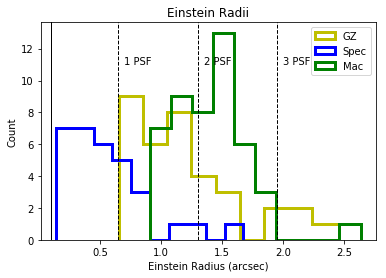

In [24]:
# Histogram of Einstein Radii
plt.xlabel("Einstein Radius (arcsec)")
plt.ylabel("Count")
plt.title("Einstein Radii")
plt.hist(zoo.theta_e,bins=10,color='y',label='GZ', histtype = 'step', linewidth=3)
plt.hist(spec.theta_e2,bins=10,color='b',label='Spec', histtype = 'step', linewidth=3)
plt.hist(mac.theta_e,bins=10,color='g',label='Mac', histtype = 'step', linewidth=3)
#plt.hist(spec_121519.theta_e_chabrier,bins=10,color='b',label='GAMA', histtype = 'step', linewidth=3)
plt.legend(loc='upper right')
plt.axvline(0.65, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.3, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.95, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.1, color='k', linestyle='solid', linewidth=1)
#plt.axvline(1, color='g', linestyle='dashed', linewidth=1)
plt.text(0.7, 11, '1 PSF')
plt.text(1.35, 11, '2 PSF')
plt.text(2, 11, '3 PSF')
#plt.text(1.05, 12, 'GAMA aperture', color='b', fontsize=8)
#plt.text(1.05, 13, 'minimum from training set Petrillo-2019', color = 'g', fontsize=8)
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/allmethods_theta_e.png')


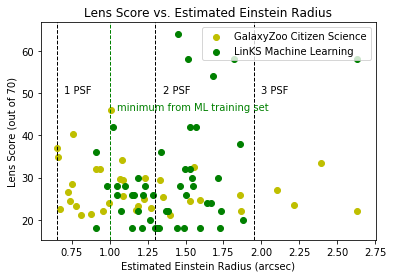

In [10]:
plt.scatter(zoo.theta_e_Ang_slide, zoo.LENS_SCORE*70,color='y',label='GalaxyZoo Citizen Science')
plt.scatter(mac.theta_e_Ang_slide, mac.SCORE,color='g',label='LinKS Machine Learning')
plt.axvline(0.65, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.3, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.95, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1, color='g', linestyle='dashed', linewidth=1)
plt.text(0.7, 50, '1 PSF')
plt.text(1.35, 50, '2 PSF')
plt.text(2, 50, '3 PSF')
plt.text(1.05, 46, 'minimum from ML training set', color = 'g')
plt.title('Lens Score vs. Estimated Einstein Radius')
plt.xlabel("Estimated Einstein Radius (arcsec)")
plt.ylabel("Lens Score (out of 70)")
plt.legend(loc='upper right')
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/mac_zoo_theta_e_score.png')
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/Final_PDFs_for_Paper/mac_zoo_theta_e_score.pdf')

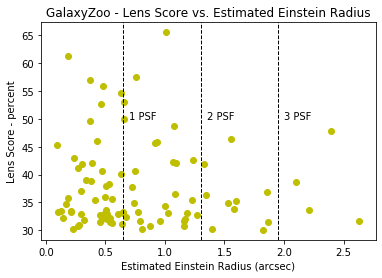

In [12]:
plt.scatter(zoo_30.theta_e, zoo_30.LENS_SCORE * 100,color='Y',label='Zoo')
plt.axvline(0.65, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.3, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.95, color='k', linestyle='dashed', linewidth=1)
#plt.axvline(1, color='g', linestyle='dashed', linewidth=1)
plt.text(0.7, 50, '1 PSF')
plt.text(1.35, 50, '2 PSF')
plt.text(2, 50, '3 PSF')
#plt.text(1.05, , 'minimum from training set', color = 'g')
plt.title('GalaxyZoo - Lens Score vs. Estimated Einstein Radius')
plt.xlabel("Estimated Einstein Radius (arcsec)")
plt.ylabel("Lens Score - percent")
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/zoo_theta_e_score.png')
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/Final_PDFs_for_Paper/zoo_theta_e_score.pdf')

# 26/06/20 - Seeing what these look like taking the 32% of the stellar mass for the f_dm and theta_e estimates. (de Vaucouleurs)

In [5]:
spec['f_dm_half_re'] = 0.13 * np.log10(0.32*spec.STELLAR_MASS/(10**11)) + 0.54
mac['f_dm_half_re'] =  0.13 * np.log10(0.32*mac.STELLAR_MASS/(10**11)) + 0.54
zoo['f_dm_half_re'] =  0.13 * np.log10(0.32*zoo.STELLAR_MASS/(10**11)) + 0.54

In [7]:
# estimate einstein radius
M = 0.32*spec.STELLAR_MASS/(1 - spec.f_dm_half_re) # total mass assuming FDM from Auger 2010
Z1 = spec.z1
Z2 = spec.z2

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = spec.D1#cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = spec.D2#cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
#B_H = ((h0/c)*(abs(Z1 - Z2)/(Z1*Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)
#spec['theta_e_H0_slide'] = A * B_H
spec['theta_e_Ang_slide_half_re'] = A * B
#spec['theta_e_comdist'] = A*B #gives arcsecs
#spec['D1'] = D1
#spec['D2'] = D2
spec.theta_e_Ang_slide_half_re

0     0.311724
1          NaN
2     0.360842
3     0.293707
4     0.383531
5          NaN
6     0.538805
7     0.368869
8     0.224218
9          NaN
10    0.323119
11    0.323277
12    0.238540
13         NaN
14    0.406534
15    0.371557
16    0.346984
17         NaN
18    0.401509
19    0.351335
20         NaN
21         NaN
22         NaN
23    0.072917
24         NaN
25    0.430488
26    0.825294
27    0.454244
28         NaN
29         NaN
30         NaN
31         NaN
32         NaN
33    0.556987
34         NaN
35         NaN
36    0.462179
37    0.500422
38    0.320395
39    0.204286
40    0.336732
41    0.104665
42    0.457502
43    0.442942
44    0.177163
45    0.221596
46    0.443538
Name: theta_e_Ang_slide_half_re, dtype: float64

In [7]:
# estimate einstein radius
M = 0.32*mac.STELLAR_MASS/(1 - mac.f_dm) # total mass assuming FDM 0.61%
Z1 = mac.Z
#Z2 = 2*mac.Z

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = 2*D1
#D2 = cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
#B_H = ((h0/c)*(1/(Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)

#mac['theta_e_H0_slide'] = A*B_H
mac['theta_e_Ang_slide_half_re'] = A*B #gives arcsecs
mac.theta_e_Ang_slide_half_re

0     1.011035
1     1.031726
2     1.480788
3     0.968020
4     0.786536
5     1.027271
6     1.117375
7     0.722841
8     0.794784
9     0.848785
10    0.983350
11    0.728351
12    0.877790
13    0.762105
14    1.164246
15    1.101804
16    1.052614
17    0.964001
18    0.908334
19    0.537838
20    0.940666
21    0.739921
22    0.589833
23    1.092706
24    0.691848
25    0.810137
26    0.671403
27    1.022401
28    0.985003
29    0.695829
30    0.794871
31    0.773192
32    1.562797
33    1.211676
34    0.633161
35    0.953860
36    0.931603
37    0.636567
38    0.743469
39    0.812069
40    1.298002
41    0.954873
42    1.279363
43    1.132334
44    1.221786
45    0.528304
46    0.738875
Name: theta_e_Ang_slide_half_re, dtype: float64

In [8]:
# estimate einstein radius
M = 0.32*zoo.STELLAR_MASS/(1 - zoo.f_dm) # total mass assuming FDM 0.61%
Z1 = zoo.Z
#Z2 = 2*zoo.Z

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = 2*D1
#D2 = cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
#B_H = ((h0/c)*(1/(Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)

#zoo['theta_e_H0_slide'] = A*B_H
zoo['theta_e_Ang_slide_half_re'] = A*B #gives arcsecs
zoo.theta_e_Ang_slide_half_re

0     0.787982
1     0.584463
2     1.043167
3     0.531564
4     0.765863
5     0.691848
6     1.243056
7     0.399994
8     1.562797
9     0.544330
10    0.805250
11    0.565193
12    0.465609
13    0.483059
14    0.545136
15    0.638315
Name: theta_e_Ang_slide_half_re, dtype: float64

/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


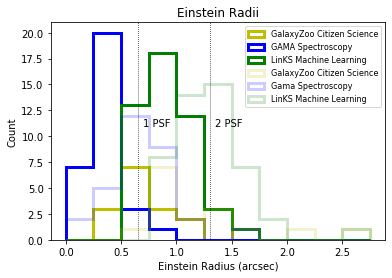

In [14]:
# Histogram of Einstein Radii
plt.xlabel("Einstein Radius (arcsec)")
plt.ylabel("Count")
plt.title("Einstein Radii")
plt.hist(zoo.theta_e_Ang_slide_half_re,bins=11,range=[0.0,2.75],color='y',label='GalaxyZoo Citizen Science', histtype = 'step', linewidth=3)
plt.hist(spec.theta_e_Ang_slide_half_re,bins=11,range=[0.0,2.75],color='b',label='GAMA Spectroscopy', histtype = 'step', linewidth=3)
plt.hist(mac.theta_e_Ang_slide_half_re,bins=11,range=[0.0,2.75],color='g',label='LinKS Machine Learning', histtype = 'step', linewidth=3)
#plt.hist(spec_121519.theta_e_chabrier,bins=10,color='b',label='GAMA', histtype = 'step', linewidth=3)

#plt.axvline(0.65, color='k', linestyle='dashed', linewidth=1)
#plt.axvline(1.3, color='k', linestyle='dashed', linewidth=1)
#plt.axvline(1.95, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.65, color='k', linestyle='dotted', linewidth=0.75)
plt.axvline(1.3, color='k', linestyle='dotted', linewidth=0.75)
#plt.axvline(0.1, color='k', linestyle='solid', linewidth=1)
#plt.axvline(1, color='g', linestyle='dashed', linewidth=1)
plt.text(0.7, 11, '1 PSF')
plt.text(1.35, 11, '2 PSF')
#plt.text(2, 11, '3 PSF')
#plt.text(1.05, 12, 'GAMA aperture', color='b', fontsize=8)
#plt.text(1.05, 13, 'minimum from training set Petrillo-2019', color = 'g', fontsize=8)
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/allmethods_theta_e.png')
plt.hist(zoo.theta_e_Ang_slide,bins=11,range=[0.0,2.75],color='y',label='GalaxyZoo Citizen Science', histtype = 'step', linewidth=3, alpha = 0.2)
plt.hist(spec.theta_e_Ang_slide,bins=11,range=[0.0,2.75],color='b',label='Gama Spectroscopy', histtype = 'step', linewidth=3,  alpha = 0.2)
plt.hist(mac.theta_e_Ang_slide,bins=11,range=[0.0,2.75],color='g',label='LinKS Machine Learning', histtype = 'step', linewidth=3,  alpha = 0.2)
plt.legend(loc='upper right', fontsize=8)

#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/theta_e_point_mass_half_re_fdm.png')

# Now lets try with this M_re/2 to M* relation...
$M_{r_e/2} = 0.0011(M_*)^{1.25}$
# Alright, now they are even smaller...

In [23]:
spec['lensing_mass_half_effective_radius'] = 0.0011 * (spec.STELLAR_MASS) ** 1.25
spec.mass_half_effective_radius

0     1.387712e+10
1              NaN
2     5.106522e+10
3     5.415783e+09
4     5.015901e+10
5              NaN
6     7.890655e+10
7     1.004649e+11
8     1.394119e+09
9              NaN
10    2.138272e+10
11    1.753123e+10
12    2.828990e+09
13             NaN
14    8.776927e+10
15    4.825336e+10
16    2.127038e+11
17             NaN
18    9.774607e+10
19    4.560482e+10
20             NaN
21             NaN
22             NaN
23    3.230955e+08
24             NaN
25    2.706545e+10
26    9.394814e+10
27    5.169105e+10
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33    9.740725e+10
34             NaN
35             NaN
36    6.457555e+10
37    5.493339e+10
38    3.342205e+10
39    3.807617e+09
40    8.167624e+10
41    1.657528e+08
42    1.446447e+10
43    1.224639e+11
44    1.076574e+10
45    1.254852e+10
46    5.550028e+10
Name: mass_half_effective_radius, dtype: float64

In [24]:
# estimate einstein radius
#M = 0.32*spec.STELLAR_MASS/(1 - spec.f_dm_half_re) # total mass assuming FDM from Auger 2010
M = spec.lensing_mass_half_effective_radius
#Z1 = spec.z1
#Z2 = spec.z2

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = spec.D1#cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = spec.D2#cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
#B_H = ((h0/c)*(abs(Z1 - Z2)/(Z1*Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)
#spec['theta_e_H0_slide'] = A * B_H
spec['theta_e_half_radius'] = A * B
#spec['theta_e_comdist'] = A*B #gives arcsecs
#spec['D1'] = D1
#spec['D2'] = D2
spec.theta_e_half_radius

0     0.287133
1          NaN
2     0.359312
3     0.254930
4     0.381511
5          NaN
6     0.549953
7     0.381585
8     0.177939
9          NaN
10    0.305609
11    0.302086
12    0.198464
13         NaN
14    0.417417
15    0.368774
16    0.373633
17         NaN
18    0.414723
19    0.347565
20         NaN
21         NaN
22         NaN
23    0.052315
24         NaN
25    0.412974
26    0.850591
27    0.452635
28         NaN
29         NaN
30         NaN
31         NaN
32         NaN
33    0.575208
34         NaN
35         NaN
36    0.466440
37    0.500396
38    0.311239
39    0.173311
40    0.344363
41    0.071621
42    0.422492
43    0.463197
44    0.160630
45    0.202846
46    0.443776
Name: theta_e_half_radius, dtype: float64

In [10]:
mac['lensing_mass_half_effective_radius'] = 0.0011 * (mac.STELLAR_MASS) ** 1.25
M = mac.lensing_mass_half_effective_radius
# estimate einstein radius
#M = 0.32*mac.STELLAR_MASS/(1 - mac.f_dm) # total mass assuming FDM 0.61%
Z1 = mac.Z
#Z2 = 2*mac.Z

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = 2 * D1
#D2 = cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
#B_H = ((h0/c)*(1/(Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)

#mac['theta_e_H0_slide'] = A*B_H
mac['theta_e_half_radius'] = A*B #gives arcsecs
mac.theta_e_half_radius

0     1.022424
1     1.038766
2     1.565018
3     0.968208
4     0.776435
5     1.037398
6     1.134447
7     0.694898
8     0.775408
9     0.835376
10    0.984618
11    0.698128
12    0.872741
13    0.748422
14    1.188305
15    1.122463
16    1.066769
17    0.954967
18    0.782229
19    0.500759
20    0.929773
21    0.716781
22    0.555745
23    1.112722
24    0.645822
25    0.792228
26    0.648187
27    1.010082
28    0.997257
29    0.674822
30    0.743698
31    0.742798
32    1.568607
33    1.233102
34    0.604070
35    0.962521
36    0.913350
37    0.605086
38    0.725320
39    0.801877
40    1.346861
41    0.959628
42    1.311710
43    1.157217
44    1.254872
45    0.488299
46    0.724465
Name: theta_e_half_radius, dtype: float64

In [11]:
zoo['lensing_mass_half_effective_radius'] = 0.0011 * (zoo.STELLAR_MASS) ** 1.25
M = zoo.lensing_mass_half_effective_radius
# estimate einstein radius
#M = 0.32*mac.STELLAR_MASS/(1 - mac.f_dm) # total mass assuming FDM 0.61%
Z1 = zoo.Z
#Z2 = 2*zoo.Z

# 06/08/20 - cosmological distances
#dL = cosmo.luminosity_distance(z) 
#dM = cosmo.comoving_distance(z)
#dA = dM/(1.+z) # THIS IS THE ONE WE NEED
D1 = cosmo.comoving_distance(Z1)/(1.0 + Z1)
D2 = 2 * D1
#D2 = cosmo.comoving_distance(Z2)/(1.0 + Z2)
# results in Mpc
#print(D1)
# mass term
#A = (M/(10**11.09))**(1/2) # Gpc
A = (M/(10**(8.09)))**(1/2) # Mpc

# distances term, h0*1000 gives km/Gpc*s
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
### I had the below "B" calculation incorrect before... c/h0 was outside the square root
#B = ((c/(h0*1000))*((Z1 * Z2 / abs(Z1 - Z2))))**(-1.2)#(2*Z))**(-1/2)
#B_H = ((h0/c)*(1/(Z2)))**(1/2)
# reassess with D1 and D2 instead of the above.(c/(h0*1000)) factor is unnecessary. Mpc
B = (abs(D1 - D2)/(D1 * D2))**(1/2)#(2*Z))**(-1/2)
#print(B_H, B)

#mac['theta_e_H0_slide'] = A*B_H
zoo['theta_e_half_radius'] = A*B #gives arcsecs
zoo.theta_e_half_radius

0     0.708867
1     0.529691
2     0.998731
3     0.473513
4     0.713148
5     0.645822
6     1.231004
7     0.348401
8     1.568607
9     0.468502
10    0.726102
11    0.506541
12    0.403123
13    0.423074
14    0.494699
15    0.585466
Name: theta_e_half_radius, dtype: float64

/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


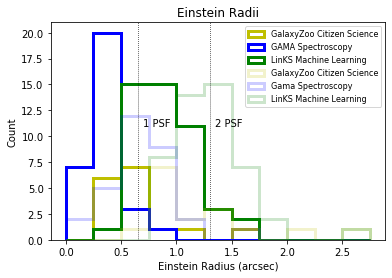

In [15]:
# Histogram of Einstein Radii
plt.xlabel("Einstein Radius (arcsec)")
plt.ylabel("Count")
plt.title("Einstein Radii")
plt.hist(zoo.theta_e_half_radius,bins=11,range=[0.0,2.75],color='y',label='GalaxyZoo Citizen Science', histtype = 'step', linewidth=3)
plt.hist(spec.theta_e_half_radius,bins=11,range=[0.0,2.75],color='b',label='GAMA Spectroscopy', histtype = 'step', linewidth=3)
plt.hist(mac.theta_e_half_radius,bins=11,range=[0.0,2.75],color='g',label='LinKS Machine Learning', histtype = 'step', linewidth=3)
#plt.hist(spec_121519.theta_e_chabrier,bins=10,color='b',label='GAMA', histtype = 'step', linewidth=3)

#plt.axvline(0.65, color='k', linestyle='dashed', linewidth=1)
#plt.axvline(1.3, color='k', linestyle='dashed', linewidth=1)
#plt.axvline(1.95, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.65, color='k', linestyle='dotted', linewidth=0.75)
plt.axvline(1.3, color='k', linestyle='dotted', linewidth=0.75)
#plt.axvline(0.1, color='k', linestyle='solid', linewidth=1)
#plt.axvline(1, color='g', linestyle='dashed', linewidth=1)
plt.text(0.7, 11, '1 PSF')
plt.text(1.35, 11, '2 PSF')
#plt.text(2, 11, '3 PSF')
#plt.text(1.05, 12, 'GAMA aperture', color='b', fontsize=8)
#plt.text(1.05, 13, 'minimum from training set Petrillo-2019', color = 'g', fontsize=8)
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/allmethods_theta_e.png')
plt.hist(zoo.theta_e_Ang_slide,bins=11,range=[0.0,2.75],color='y',label='GalaxyZoo Citizen Science', histtype = 'step', linewidth=3, alpha = 0.2)
plt.hist(spec.theta_e_Ang_slide,bins=11,range=[0.0,2.75],color='b',label='Gama Spectroscopy', histtype = 'step', linewidth=3,  alpha = 0.2)
plt.hist(mac.theta_e_Ang_slide,bins=11,range=[0.0,2.75],color='g',label='LinKS Machine Learning', histtype = 'step', linewidth=3,  alpha = 0.2)
plt.legend(loc='upper right', fontsize=8)

#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/theta_e_point_mass_half_re_lensing_mass.png')

(array([ 7.,  9.,  9., 13.,  6.,  2.,  0.,  0.,  0.,  1.]),
 array([0.80755413, 0.98576102, 1.16396791, 1.34217479, 1.52038168,
        1.69858857, 1.87679545, 2.05500234, 2.23320923, 2.41141611,
        2.589623  ]),
 <a list of 10 Patch objects>)

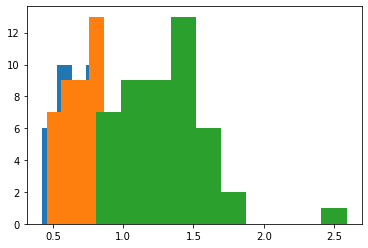

In [29]:
plt.hist(mac.theta_e_half_radius)
plt.hist(mac.theta_e_Ang_slide_half_re)
plt.hist(mac.theta_e_Ang_slide)

In [6]:
mac.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'GAMA_ID', 'ID', 'RA', 'DEC', 'SCORE', 'STELLAR_MASS', 'Z', 'theta_e',
       'theta_e_H0', 'theta_e_Ang', 'f_dm', 'theta_e_H0_slide',
       'theta_e_Ang_slide', 'f_dm_half_re', 'theta_e_Ang_slide_half_re',
       'lensing_mass_half_effective_radius', 'theta_e_half_radius', 'sigma',
       'theta_e_veldisp'],
      dtype='object')